# Multipole model exploration

In [28]:
import h5py
import os
import numpy as np
from tqdm import tqdm

data_dir = "/home/nino/GW/Keras-Project-Template/data/q_multipole"

data = []
files = os.listdir(data_dir)

with h5py.File(os.path.join(data_dir, files[0])) as f20:
    with h5py.File(os.path.join(data_dir, files[0])) as f21:
        with h5py.File(os.path.join(data_dir, files[0])) as f2n2:
            with h5py.File(os.path.join(data_dir, files[0])) as f22:
                with h5py.File(os.path.join(data_dir, files[0])) as f2n1:

                    for w20, w21, w2n2, w22, w2n1 in tqdm(zip(f20["waveforms"][:], f21["waveforms"][:], f2n2["waveforms"][:], f22["waveforms"][:], f2n1["waveforms"][:]), total = 100000):
                        data.append([w22, w21, w20, w2n1, w2n2])

data = np.array(data)
data.shape

bbh_q20_data.hdf5
bbh_q21_data.hdf5
bbh_q2n2_data.hdf5
bbh_q22_data.hdf5
bbh_q2n1_data.hdf5


In [14]:
import keras
from keras import layers
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

inp = keras.Input((5, 2048))

x = layers.Reshape((1, 5, 2048))(inp)
x = layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (1, 3), activation = "leaky_relu", kernel_initializer = "glorot_uniform", data_format = "channels_first")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'leaky_relu', kernel_initializer = "glorot_uniform")(x)
x = layers.Dense(512, activation = 'leaky_relu', kernel_initializer = "glorot_uniform")(x)

enc = layers.Dense(10)(x)

y = layers.Dense(5*2048, activation="leaky_relu", kernel_initializer = "glorot_uniform")(enc)
opt = layers.Reshape((5, 2048))(y)

multimode_autoencoder = keras.Model(inp, opt)

multimode_autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5, 2048)]         0         
                                                                 
 reshape_8 (Reshape)         (None, 1, 5, 2048)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 1, 682)        1664      
                                                                 
 flatten_8 (Flatten)         (None, 43648)             0         
                                                                 
 dense_21 (Dense)            (None, 512)               22348288  
                                                                 
 dense_22 (Dense)            (None, 10)                5130      
                                                                 
 dense_23 (Dense)            (None, 10240)             1126

In [30]:
multimode_autoencoder.compile(optimizer = 'adam', loss = 'mae')

multimode_autoencoder.fit(data[:10000], data[:10000], epochs = 200, batch_size = 50)

2024-05-23 18:17:48.836537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 4.48G (4809359360 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-05-23 18:17:48.838836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 4.03G (4328423424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Epoch 1/200
200/200 [==============================] - 4s 12ms/step - loss: 0.0141
Epoch 2/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0077
Epoch 3/200
200/200 [==============================] - 2s 11ms/step - loss: 0.0064
Epoch 4/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0058
Epoch 5/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0054
Epoch 6/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0052
Epoch 7/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0050
Epoch 8/200
200/200 [==============================] - 3s 13ms/step - loss: 0.0047
Epoch 9/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0045
Epoch 10/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0043
Epoch 11/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0040
Epoch 12/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0038
E

4/4 [==============================] - 0s 14ms/step


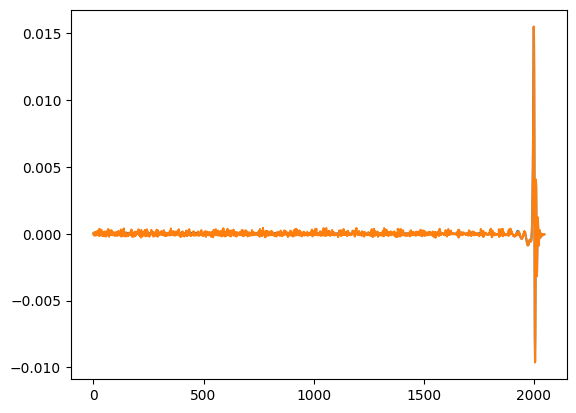

In [26]:
import matplotlib.pyplot as plt

ae_data = multimode_autoencoder.predict(data[:1000], batch_size=256)

plt.plot(data[0, 2])
plt.plot(ae_data[0, 2])

# Model evaluation

In [1]:
import tensorflow as tf
from utils.eval import load_model_and_data_loader
from utils.config import process_config
from utils.plot_utils import *
from data_loader.gw_dataloader import GWDataLoader
import keras

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

model_dir = "/home/nino/GW/Keras-Project-Template/experiments/multipole_q_reg/full_model.hdf5"
config_path = "/home/nino/GW/Keras-Project-Template/experiments/q_bbh_reg_light/reg_q_bbh_light/checkpoints/config.json"
data_folder = "/home/nino/GW/Keras-Project-Template/data/q_multipole"

config, _ = process_config(config_path)
model, data_loader = load_model_and_data_loader("/home/nino/GW/Keras-Project-Template/experiments/q_bbh_reg_light/reg_q_bbh_light/checkpoints")

def define_model(base_model):

    nozz_22 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-1].input, base_model.layers[-1].layers[-1].output))
    nozz_21 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-2].input, base_model.layers[-1].layers[-1].output))
    nozz_20 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-3].input, base_model.layers[-1].layers[-1].output))
    nozz_2n1 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-2].input, base_model.layers[-1].layers[-1].output))
    nozz_2n2 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-1].input, base_model.layers[-1].layers[-1].output))

    inp = base_model.layers[1].input

    x = base_model.layers[1](inp)
    x = base_model.layers[2](x)

    for layer in base_model.layers[3].layers[:-4]:
        x = layer(x)

    mp20 = base_model.layers[3].layers[-4](x)
    mp21 = base_model.layers[3].layers[-3](mp20)
    mp22 = base_model.layers[3].layers[-2](mp21)

    opt_22 = nozz_22(mp22)
    opt_2n2 = nozz_2n2(mp22)
    opt_21 = nozz_21(mp21)
    opt_2n1 = nozz_2n1(mp21)
    opt_20 = nozz_20(mp20)
    
    return keras.Model(inp, [opt_20, opt_21, opt_2n1, opt_22, opt_2n2])

2024-05-24 16:14:53.153270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 16:14:53.342630: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 16:14:54.418191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nino/miniconda3/envs/Tensorflow/lib/
2024-05-24 16:14:54.418307: W tensorflow/co

2024-05-24 16:15:34.250728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 16:15:35.328889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3174 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Loading model checkpoint /home/nino/GW/Keras-Project-Template/experiments/q_bbh_reg_light/reg_q_bbh_light/checkpoints/best_model.hdf5 ...

Model loaded


In [4]:
multimode_model = define_model(model)
multimode_model.load_weights(model_dir)
test_wv = multimode_model.predict(np.array([[1.7, 1.3], [2.5, 1.7]]))

1/1 [==============================] - 0s 225ms/step


In [16]:
np.max(test_wv[0][0])

0.07861644

In [11]:
multimode_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 model_1 (Functional)           (None, 10)           6666        ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 10)           536074      ['model_1[2][0]']                
                                                                                                  
 input_4 (InputLayer)           multiple             0           ['model[2][0]']                  
                                                                                           

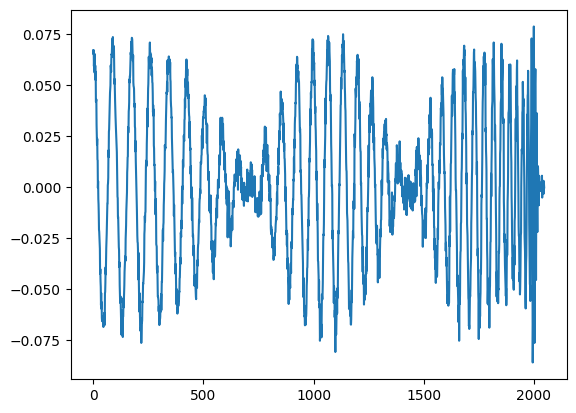

In [9]:
import matplotlib.pyplot as plt

_=plt.plot(test_wv[0][0])

# Keras' overlap loss function

In [19]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-05-26 10:04:12.589954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 10:04:12.785871: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 10:04:13.624791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nino/miniconda3/envs/Tensorflow/lib/
2024-05-26 10:04:13.624880: W tensorflow/co

In [46]:
from tensorflow.signal import fft
from keras.losses import mean_absolute_error

def overlap(y_pred, y_true):

    h_pred = fft(y_pred)
    h_true = fft(y_true)

    ovlp = tf.tensordot(h_pred, tf.math.conj(h_true), axes = 1) / tf.math.sqrt(tf.tensordot(h_true, tf.math.conj(h_true), axes = 1) * tf.tensordot(h_pred, tf.math.conj(h_pred), axes = 1))

    return 1. - tf.math.abs(ovlp)

def ovlp_mae_loss(y_pred, y_true):
    
    return overlap(y_pred, y_true) + mean_absolute_error(y_pred, y_true)

In [43]:
y_pred = f['waveforms'][0]
y_true = f['waveforms'][0]

h_pred = fft(y_pred)
h_true = fft(y_true)

tf.tensordot(h_pred, tf.math.conj(h_true), axes = 1)

<tf.Tensor: shape=(), dtype=complex64, numpy=(63097.01+1.5429738e-05j)>

In [58]:
model.predict(np.array([[1.2 + 1.0j*0.0, 1.1 + 1.0j*0.0], [1.5 + 1.0j*0.0, 1.4 + 1.0j*0.0]], dtype = np.complex64))

1/1 [==============================] - 0s 25ms/step


array([[-0.00494633,  0.10391558,  0.03238547, ..., -0.04687277,
         0.00442477,  0.00188048],
       [-0.00607211,  0.13152   ,  0.04032306, ..., -0.05880735,
         0.00600991,  0.00288942]], dtype=float32)

In [62]:
import keras
from keras import layers
import h5py
import numpy as np
from data_loader.gw_dataloader import DataGenerator

f = h5py.File("./data/bbh_q_data.hdf5")

inp = keras.Input(2, dtype = tf.complex128)
x = layers.Dense(1024, activation='leaky_relu')(inp)
opt = layers.Dense(2048)(tf.cast(x, tf.complex128))

model = keras.Model(inp, tf.cast(opt, tf.complex128))

model.compile(optimizer = 'adam', metrics = [overlap, mean_absolute_error], loss = ovlp_mae_loss)

gen_tr = DataGenerator(f['parameters'][:10000], f['waveforms'][:10000], batch_size = 64)
gen_ts = DataGenerator(f['parameters'][10000:12000], f['waveforms'][10000:12000], batch_size = 512)

In [63]:
model.fit(gen_tr , validation_data = gen_ts, epochs = 300, batch_size = 64)

Epoch 1/300


TypeError: in user code:

    File "/home/nino/miniconda3/envs/Tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_1621552/2238347224.py", line 6, in overlap  *
        h_pred = fft(y_pred)

    TypeError: Value passed to parameter 'input' has DataType float32 not in list of allowed values: complex64, complex128
